In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk import tokenize
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from string import punctuation
from razdel import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from natasha import MorphVocab, Doc, Segmenter, NewsEmbedding, NewsMorphTagger

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
df = pd.read_csv('e-catalog_phone_reviews.csv', index_col=0)

In [3]:
df

,review,type
0,Советую модель на 128 GB. Именно Pro в ней ест...,/img/svg/review-smile-4.svg
1,"Телефон - огонь) Хорошая модель, мне понравило...",/img/svg/review-smile-4.svg
2,"Аппарат очень хороший,конечно рекомендую к пре...",/img/svg/review-smile-4.svg
3,"Уверен, что телефон своих денег стои, а баланс...",/img/svg/review-smile-3.svg
4,"Всем рекомендую) Итак, искал я телефон для пок...",/img/svg/review-smile-4.svg
...,...,...
3685,"Не берите,за эти деньги можно найти и получше....",/img/svg/review-smile-1.svg
3686,модель с серьезными недостатками Тот телефон у...,/img/svg/review-smile-1.svg
3687,модель с серьезными недостатками Игры вылетают...,/img/svg/review-smile-1.svg
3688,"хорошая модель, понравилось У меня есть этот т...",/img/svg/review-smile-3.svg


## Преобразуем к четырем типам

####  (/img/svg/review-smile-4.svg) --> 1

####  (/img/svg/review-smile-3.svg) --> 2

####  (/img/svg/review-smile-2.svg) --> 3

####  (/img/svg/review-smile-1.svg) --> 4

In [4]:
def convert_to_4_types(val):
    if val == '/img/svg/review-smile-4.svg':
        return 1
    elif val == '/img/svg/review-smile-3.svg':
        return 2
    elif val == '/img/svg/review-smile-2.svg':
        return 3
    elif val == '/img/svg/review-smile-1.svg':
        return 4

In [5]:
df['type'] = df['type'].apply(lambda x: convert_to_4_types(x))

In [6]:
df['type'].value_counts(normalize=True)

1    0.565618
2    0.237527
4    0.098427
3    0.098427
Name: type, dtype: float64

### Наблюдается большой дисбаланс классов. Считаю, что можно пожертвовать частью наблюдений и произвести undersampling.

In [7]:
fewer_class = df['type'].value_counts().sort_values().head(1)
fewer_class_count = fewer_class.item()
fewer_class_count

363

In [8]:
new_df = pd.DataFrame()
for review_type in df['type'].unique():
    new_df = new_df.append(df.loc[df['type'] == review_type].sample(fewer_class_count))
df = new_df.copy()

In [9]:
df['type'].value_counts(normalize=True)

1    0.25
2    0.25
3    0.25
4    0.25
Name: type, dtype: float64

## Text Preprocessing

### Приведем к нижнему регистру

In [10]:
df['review'] = df['review'].str.lower()

### Уберем лишние символы

In [11]:
pat = r'[^0-9a-zA-zа-яёА-ЯЁ\-]'

def clean_str(val):
    
    val = re.sub(pat, ' ', val)
    
    val = val.replace(' -', ' ')
    val = val.replace('- ', ' ')
    val = val.replace(' - ', ' ')
    val = val.replace('  ', ' ')
    val = val.strip()
    
    return val

df['review'] = df['review'].apply(lambda x: clean_str(x))

### Токенизируем

In [12]:
df['review'] = df['review'].apply(lambda x: [y.text for y in tokenize(x)])

### Уберем стоп-слова и одиночные буквы

In [13]:
stop_words = stopwords.words('russian') + stopwords.words('english')

In [14]:
df['review'] = df['review'].apply(lambda x: [y for y in x if y not in stop_words and len(y) > 1])

### Лемматизация

In [15]:
morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
    
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text_list):
    doc = Doc(' '.join(text_list))
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    # лемматизация русских слов
    for token in doc.tokens:    
        token.lemmatize(morph_vocab)
    
    result = [x.lemma for x in doc.tokens]
    
    # лемматизация английских слов
    result = [lemmatizer.lemmatize(x) for x in result]

    return result

In [16]:
df['review'] = df['review'].apply(lambda x: lemmatize_text(x))

In [17]:
df['review'] = df['review'].apply(lambda x: ' '.join(x))

In [18]:
df.head()

,review,type
1642,телефон хороший магазин внимательно смотреть н...,1
1394,очень рекомендовать любитель тяжелый игра отли...,1
920,отличный модель очень понравиться телефон купи...,1
723,немного 10 рубль хотеть достойный гаджет note ...,1
2318,игровой долгоживущий функциональный аппарат вп...,1


## Count Vectorizer

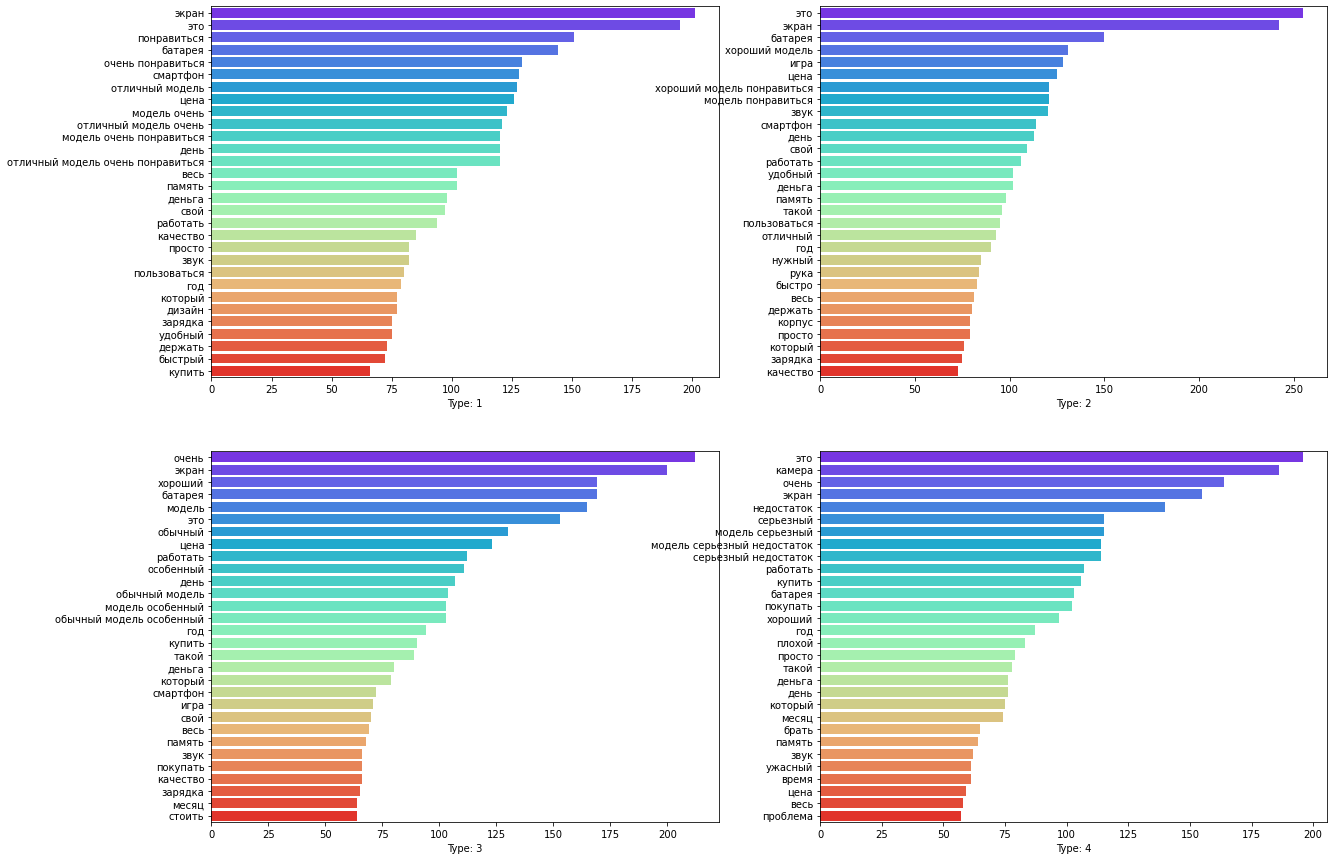

In [19]:
fig,ax = plt.subplots(2, 2, figsize=(20, 15))

i = 0
j = 0

for review_type in df['type'].unique():
    vectorizer = CountVectorizer(max_df=0.4, min_df=0.01, ngram_range=(1, 4), max_features=1000)
    words = df.loc[df['type'] == review_type]['review'].to_list()
    vector = vectorizer.fit_transform(words)
    series = pd.DataFrame(data=vector.toarray(), 
                          columns=vectorizer.get_feature_names()).sum().sort_values(ascending=False)
    
    if j == 2:
        i += 1
        j = 0
    
    ax[i, j].set_xlabel(f'Type: {review_type}')
    sns.barplot(x=series.head(30), y=series.head(30).index, palette='rainbow', ax=ax[i, j])
    
    j += 1

## Splitting

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['type'], random_state=42, test_size=0.25)

## TF IDF

In [21]:
tf_idf_vec = TfidfVectorizer(max_df=0.4, min_df=0.01, ngram_range=(1, 4), max_features=1000, norm=False)

X_train_tf = tf_idf_vec.fit_transform(X_train)
X_train_tf = pd.DataFrame(data=X_train_tf.toarray(), columns=tf_idf_vec.get_feature_names())

X_test_tf = tf_idf_vec.transform(X_test)
X_test_tf = pd.DataFrame(data=X_test_tf.toarray(), columns=tf_idf_vec.get_feature_names())

In [22]:
print(len(X_train_tf), len(X_test_tf))

1089 363


## Plot Feature Importance

In [48]:
def plot_feature_impotance(feature_impotance_array):
    fig, ax = plt.subplots(2, 2, figsize=(25, 15))

    i = 0
    j = 0

    labels = ['Positive', 'Semi-Positive', 'Semi-Negative', 'Negative']

    for label in range(len(feature_impotance_array)):
        featureImportance = pd.DataFrame({"feature": X_train_tf.columns[feature_impotance_array[label] != 0], 
                                          "importance": feature_impotance_array[label][feature_impotance_array[label]!=0]}).sort_values(by='importance', ascending=False).head(25)

        if j == 2:
            i += 1
            j = 0

        ax_i = ax[i, j]

        sns.barplot(x='importance', y='feature', data=featureImportance, ax=ax_i)

        ax_i.set_xlabel(labels[label])
        ax_i.set_ylabel(None)

        j += 1

## Naive Bayes

In [23]:
mnnb = MultinomialNB()
mnnb.fit(X_train_tf, y_train)
preds = mnnb.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8261    0.6552    0.7308        87
           2     0.5593    0.7333    0.6346        90
           3     0.6053    0.5169    0.5576        89
           4     0.7600    0.7835    0.7716        97

    accuracy                         0.6749       363
   macro avg     0.6877    0.6722    0.6736       363
weighted avg     0.6881    0.6749    0.6754       363



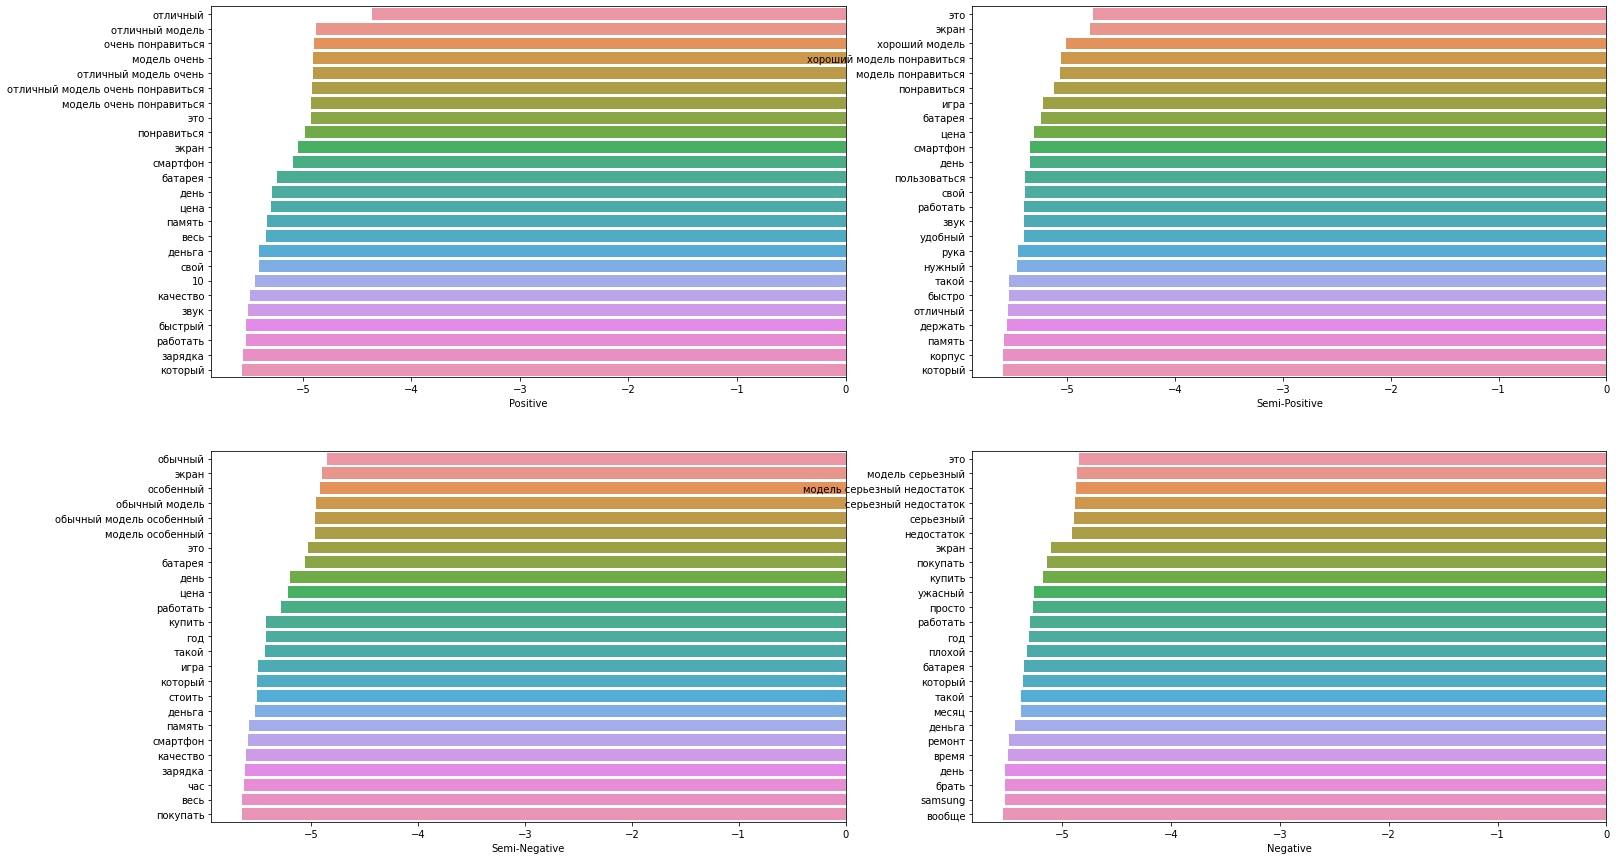

In [34]:
plot_feature_impotance(mnnb.coef_)

## Random Forest

In [24]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tf, y_train)
preds = rf.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.6744    0.6667    0.6705        87
           2     0.6386    0.5889    0.6127        90
           3     0.6364    0.5506    0.5904        89
           4     0.6667    0.8041    0.7290        97

    accuracy                         0.6556       363
   macro avg     0.6540    0.6526    0.6506       363
weighted avg     0.6541    0.6556    0.6522       363



### SVM

In [44]:
svm = SVC(random_state=42)
svm.fit(X_train_tf, y_train)
preds = svm.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8209    0.6322    0.7143        87
           2     0.6214    0.7111    0.6632        90
           3     0.5339    0.7079    0.6087        89
           4     0.8267    0.6392    0.7209        97

    accuracy                         0.6722       363
   macro avg     0.7007    0.6726    0.6768       363
weighted avg     0.7026    0.6722    0.6775       363



## Logistic Regression

In [27]:
lr_no_reg = LogisticRegression(random_state=42, penalty='none')
lr_no_reg.fit(X_train_tf, y_train)
preds = lr_no_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.6988    0.6667    0.6824        87
           2     0.5676    0.7000    0.6269        90
           3     0.6892    0.5730    0.6258        89
           4     0.7579    0.7423    0.7500        97

    accuracy                         0.6722       363
   macro avg     0.6784    0.6705    0.6712       363
weighted avg     0.6797    0.6722    0.6728       363



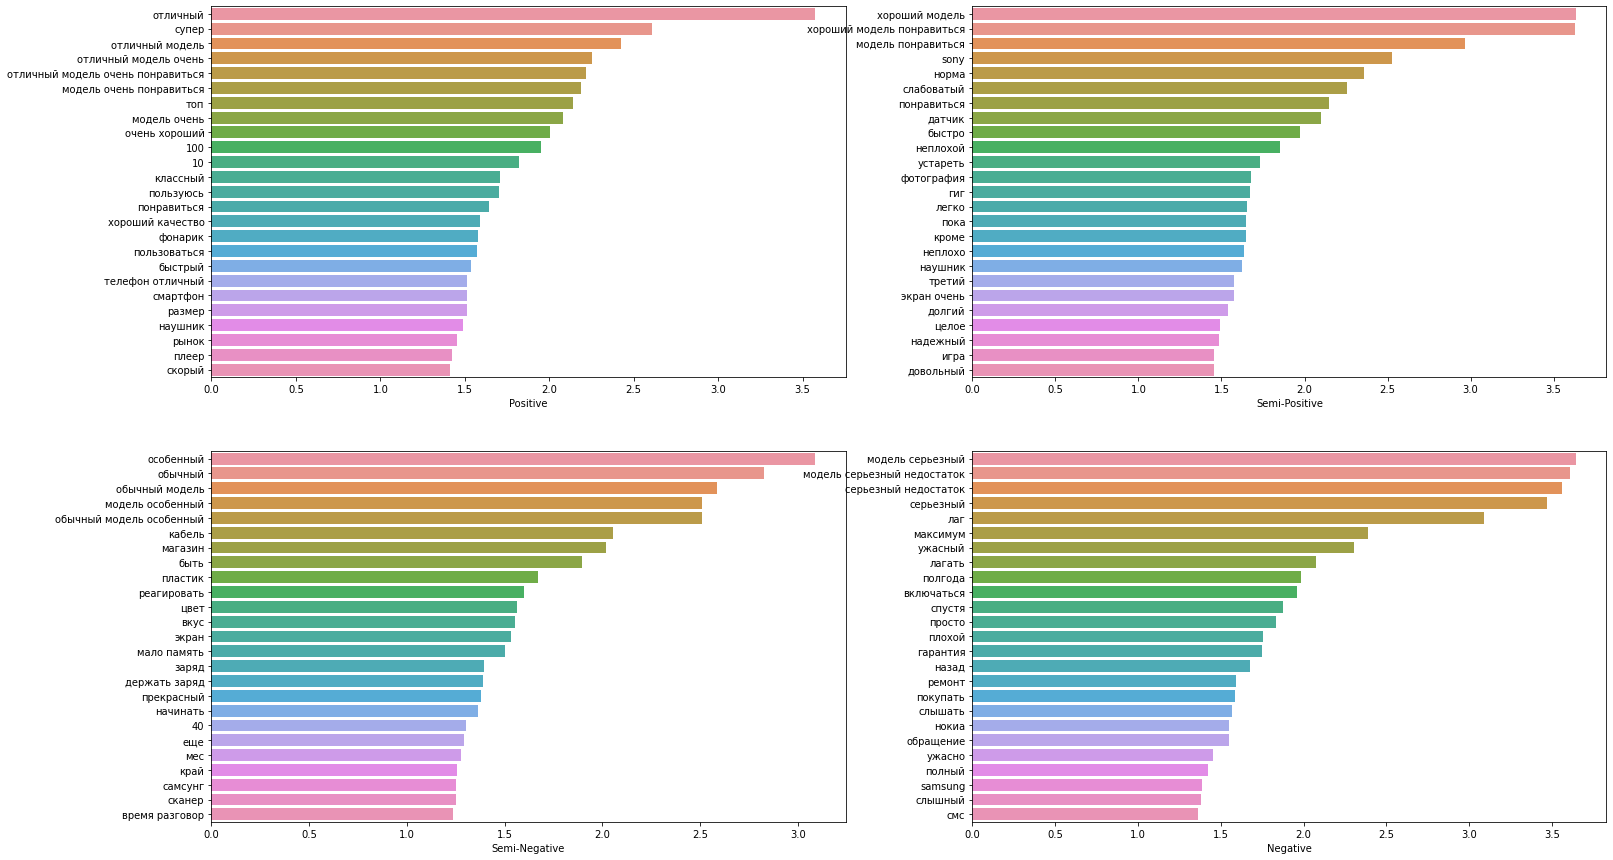

In [28]:
plot_feature_impotance(lr_no_reg.coef_)

In [29]:
lr_l2_reg = LogisticRegression(random_state=42, penalty='l2')
lr_l2_reg.fit(X_train_tf, y_train)
preds = lr_l2_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.6782    0.6782    0.6782        87
           2     0.5876    0.6333    0.6096        90
           3     0.6410    0.5618    0.5988        89
           4     0.7327    0.7629    0.7475        97

    accuracy                         0.6612       363
   macro avg     0.6599    0.6590    0.6585       363
weighted avg     0.6612    0.6612    0.6602       363



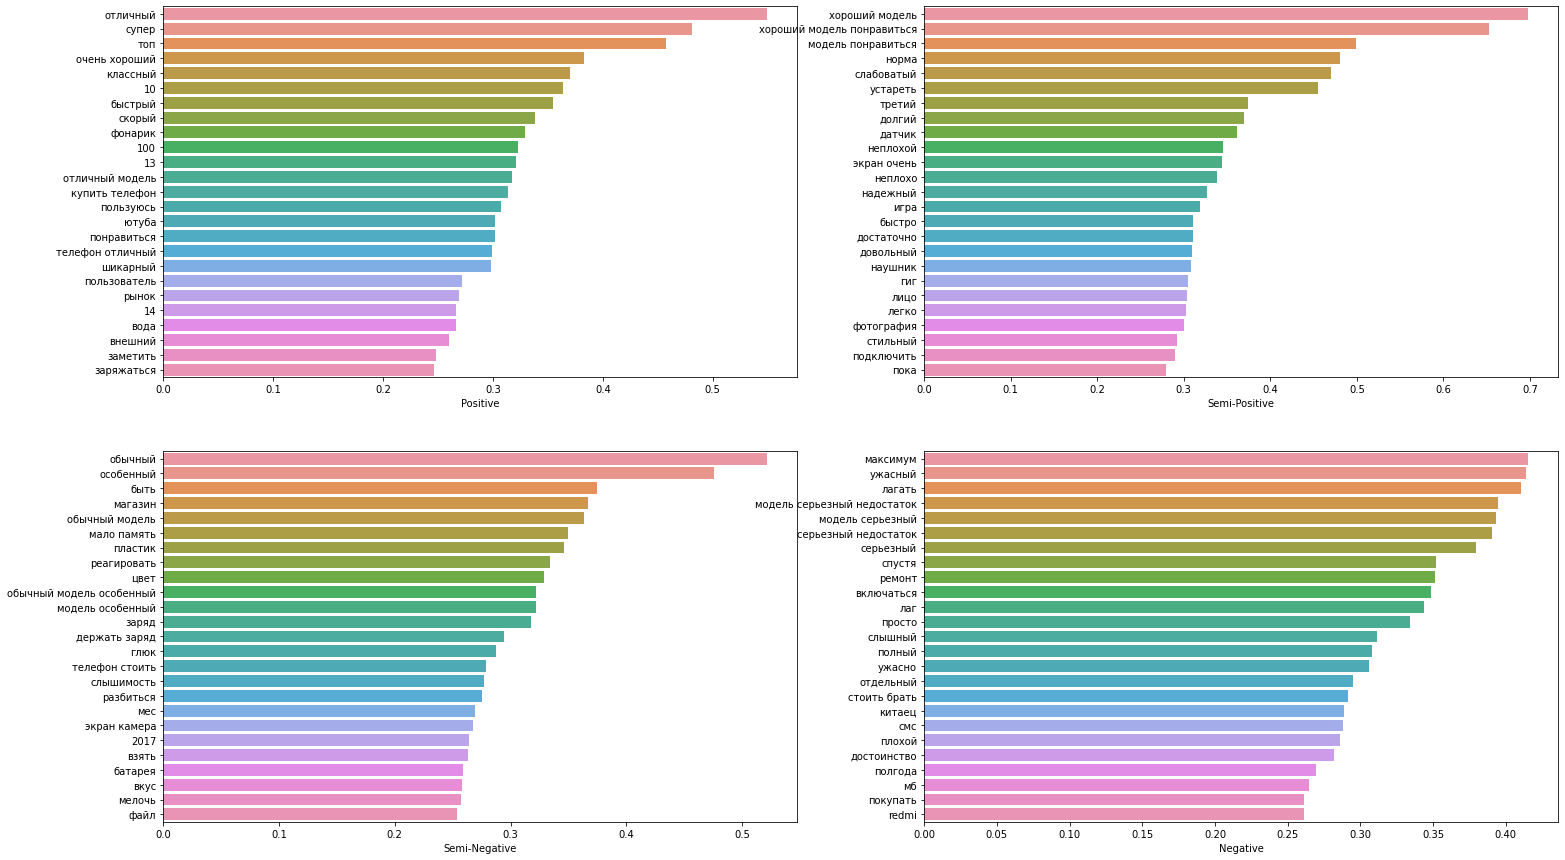

In [30]:
plot_feature_impotance(lr_l2_reg.coef_)

In [31]:
lr_l1_reg = LogisticRegression(random_state=42, penalty='l1', solver='liblinear')
lr_l1_reg.fit(X_train_tf, y_train)
preds = lr_l1_reg.predict(X_test_tf)
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.7093    0.7011    0.7052        87
           2     0.6489    0.6778    0.6630        90
           3     0.6098    0.5618    0.5848        89
           4     0.7327    0.7629    0.7475        97

    accuracy                         0.6777       363
   macro avg     0.6752    0.6759    0.6751       363
weighted avg     0.6762    0.6777    0.6765       363



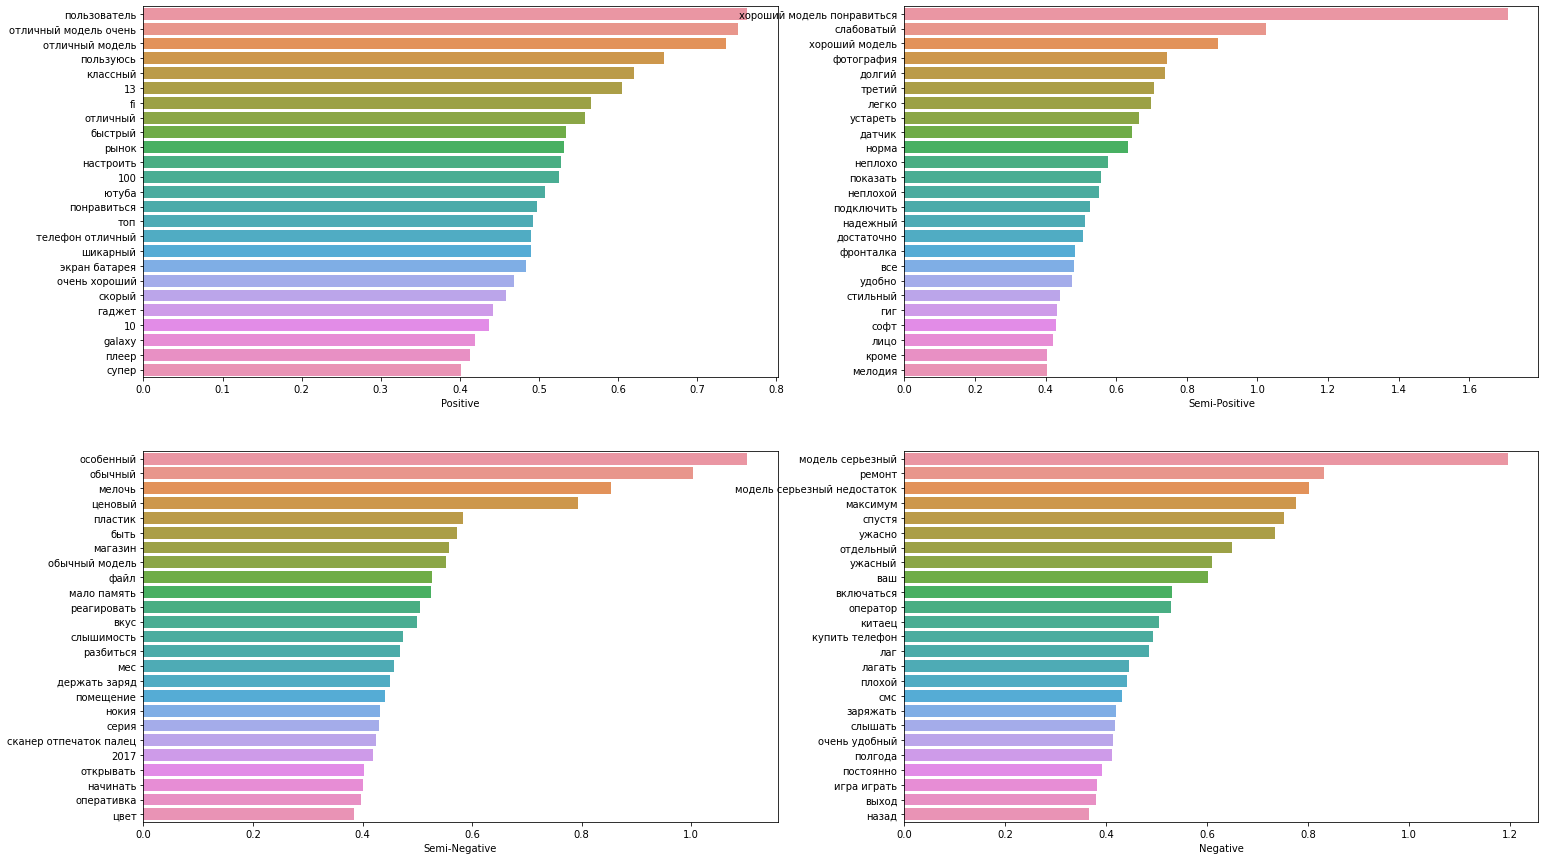

In [32]:
plot_feature_impotance(lr_l1_reg.coef_)